<a href="https://colab.research.google.com/github/colbyendres/PaperRec/blob/main/CSCE670_FP_CLUSTER_AND_EMBEDDINGS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# IMPORTS

In [2]:
import os
import glob # Import the glob module
import tarfile
import gzip
import re
import pandas as pd
from google.colab import drive
from pathlib import Path
import re
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pickle
import numpy as np

# PREREQS

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root = Path("/content/drive/MyDrive/CSCE670 DATASET")
records = []

In [ ]:
csv_path = '/content/drive/MyDrive/CSCE670 DATASET/new_df.csv'  # update to your path
df = pd.read_csv(csv_path)

print(df.shape)

(10688, 5)


In [ ]:
mask = df['abstract'].notnull() & df['abstract'].str.strip().astype(bool)
new_d2f = df.loc[mask].copy()
csv_path = '/content/drive/MyDrive/CSCE670 DATASET/5000_papers.csv'
new_d2f.to_csv(csv_path, index=False)
print(new_d2f.shape)

(5713, 5)


finding avg number of words in papers

# CLUSTERING

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
csv_path = '/content/drive/MyDrive/CSCE670 DATASET/tex_papers2.csv'  # update to your path
df = pd.read_csv(csv_path)

print(df.shape)
df.head()

(10688, 4)


,file_path,title,abstract,cleaned_full
0,/content/drive/MyDrive/CSCE670 DATASET/arxiv_s...,generev,NaN,Genetic Algorithm is based upon the theory of...
1,/content/drive/MyDrive/CSCE670 DATASET/arxiv_s...,Genetic Algorithm for SU(2) Gauge Theory on a ...,A hybrid algorithm is proposed for pure SU(N)\...,A hybrid algorithm is proposed for pure SU(N)\...
2,/content/drive/MyDrive/CSCE670 DATASET/arxiv_s...,Restart Strategies and Internet Congestion,We recently presented a methodology for quanti...,We recently presented a methodology for quanti...
3,/content/drive/MyDrive/CSCE670 DATASET/arxiv_s...,Development and Evolution of Neural Networks i...,We present a model of decentralized growth for...,We present a model of decentralized growth for...
4,/content/drive/MyDrive/CSCE670 DATASET/arxiv_s...,ofria,We examine the evolution of expression pattern...,We examine the evolution of expression pattern...


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("malteos/scincl")
model = AutoModel.from_pretrained("malteos/scincl").to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/227k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31090, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
embeddings = []
batch_size = 8
for i in range(0, len(df), batch_size):
    batch_texts = df["cleaned_full"].iloc[i : i + batch_size].tolist()
    inputs = tokenizer(
        batch_texts,
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt"
    ).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    hidden = outputs.last_hidden_state            # (B, L, D)
    mask = inputs.attention_mask.unsqueeze(-1)    # (B, L, 1)
    summed = (hidden * mask).sum(1)               # (B, D)
    counts = mask.sum(1)                          # (B, 1)
    batch_emb = (summed / counts).cpu().numpy()   # (B, D)
    embeddings.extend(batch_emb)

X = np.vstack(embeddings)
print("Embeddings matrix shape:", X.shape)

Embeddings matrix shape: (10688, 768)


In [ ]:
pca = PCA(n_components=0.80, random_state=42)
X_pca = pca.fit_transform(X)
print("PCA reduced to:", X_pca.shape)

PCA reduced to: (10688, 19)


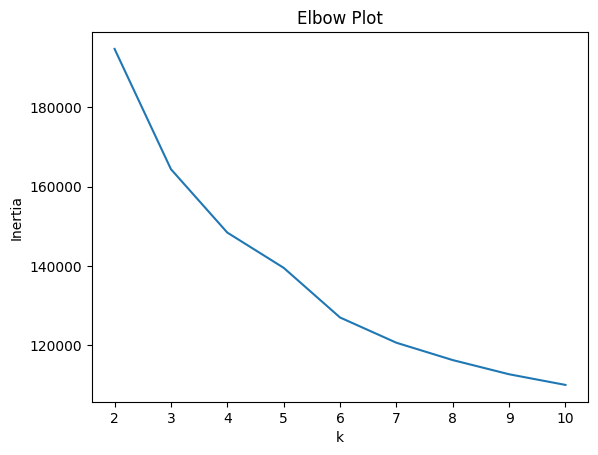

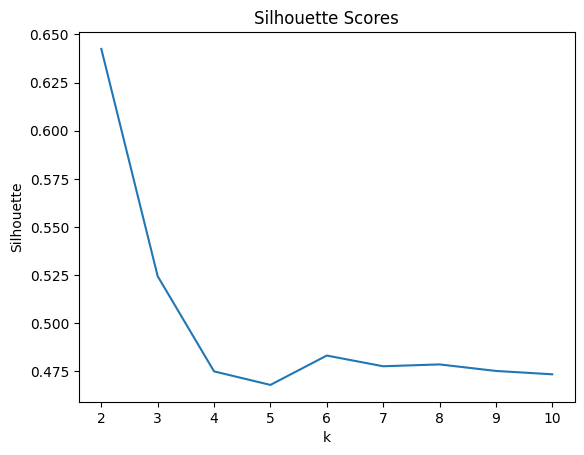

Optimal k: 2


In [ ]:
# Choose k via Elbow & Silhouette
Ks = list(range(2, 11))
inertias, sil_scores = [], []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_pca)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_pca, labels))

plt.figure()
plt.plot(Ks, inertias)
plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("Elbow Plot")
plt.show()

plt.figure()
plt.plot(Ks, sil_scores)
plt.xlabel("k"); plt.ylabel("Silhouette"); plt.title("Silhouette Scores")
plt.show()

opt_k = Ks[sil_scores.index(max(sil_scores))]
print("Optimal k:", opt_k)

In [ ]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df["cluster"] = kmeans.fit_predict(X_pca)
centroids = kmeans.cluster_centers_
print("Cluster sizes:\n", df["cluster"].value_counts())

Cluster sizes:
 cluster
1    4300
3    2021
5    1713
4    1486
0     726
2     442
Name: count, dtype: int64


In [ ]:
with open("paper_pipeline.pkl2", "wb") as f:
    pickle.dump({"df": df, "embeddings": embeddings, "pca": pca, "kmeans": kmeans}, f)
print("Saved state to paper_pipeline.pkl")

Saved state to paper_pipeline.pkl


# CHECKPOINT (PICKLE FILE EXISTS)

In [6]:
# IMPORTANT

STATE_PATH = "/content/paper_pipeline.pkl2"

if os.path.exists(STATE_PATH):
    with open(STATE_PATH, "rb") as f:
        state = pickle.load(f)
    df         = state["df"]
    embeddings = state["embeddings"]
    pca        = state["pca"]
    kmeans     = state["kmeans"]
    X = np.vstack(embeddings)
    X_pca = pca.fit_transform(X)
    print(f"Loaded df, embeddings, pca & kmeans from {STATE_PATH}")
else:
    raise FileNotFoundError(f"No saved state at {STATE_PATH}")

Loaded df, embeddings, pca & kmeans from /content/paper_pipeline.pkl2


In [7]:
centroid_idxs = []

df["abstract"] = df["abstract"].fillna("")

for c, centroid in enumerate(kmeans.cluster_centers_):
    sims = cosine_similarity(centroid.reshape(1, -1), X_pca)[0]
    idx = sims.argmax()
    centroid_idxs.append(idx)

    row = df.iloc[idx]
    title    = row["title"]
    path     = row["file_path"]
    abstract = row["abstract"] or "No abstract available"
    snippet  = abstract[:200] + ("…" if len(abstract) > 200 else "")

    print(f"Cluster {c} centroid paper:")
    print(f" • Title   : {title}")
    print(f" • File    : {path}")
    print(f" • Abstract: {snippet}\n")

# Cluster 0 labels: Alexander Stratification, Fox Calculus and Alexander Invariants, Character Varieties of Finitely Presented Groups, Kähler Group Obstructions via Binomial Ideals, Betti Numbers of Finite Abelian Coverings

# Cluster 1 labels:

# Cluster 2 labels: Context-Dependent Entity Descriptions, Semantic Constraints in Lexical Choice, Supervised Learning of Linguistic Indicators, Language Reuse in Text Generation, Information Extraction–Driven Entity Profiling

# Cluster 3 labels: Super Shell Structure of Magnetic Susceptibility, Shell Structure in Confined Fermion Systems, Semiclassical Periodic Orbit Theory, Quantum Size Effects in Metal Clusters and Quantum Dots, Canonical Ensemble Effects on Mesoscopic Susceptibility

# Cluster 4 labels: Passive Tracer Dispersion in Closed Basins, Finite‑Size Lyapunov Exponents, Scale‑Dependent Diffusion Coefficients, Fixed‑Scale Mixing Analysis, Lagrangian Chaos in Bounded Flows

# Cluster 5 labels: d-wave superconductivity, twin boundaries, time-reversal symmetry breaking, Bogoliubov–de Gennes modeling, extended Hubbard interactions

Cluster 0 centroid paper:
 • Title   : Alexander Stratifications of
Character Varieties
 • File    : /content/drive/MyDrive/CSCE670 DATASET/arxiv_source1/alg-geom/9602004v2/9602004.tex
 • Abstract: Equations defining the jumping loci for the first cohomology group 
of one-dimensional representations of a finitely presented group 
$\Gamma$ can be effectively computed using Fox calculus.  In this …

Cluster 1 centroid paper:
 • Title   : fig110
 • File    : /content/drive/MyDrive/CSCE670 DATASET/arxiv_source/adap-org/9909006v2/fig110.tex
 • Abstract: No abstract available

Cluster 2 centroid paper:
 • Title   : {\Large Learning Correlations between Linguistic Indicators and Semantic
Constraints:
 • File    : /content/drive/MyDrive/CSCE670 DATASET/arxiv_source/cmp-lg/9806001v1/reuse.tex
 • Abstract: This paper presents the results of a study on the semantic constraints
imposed on lexical choice by certain contextual indicators. We show how
such indicators are computed and how correlations

In [8]:
def recommend(title, top_n=5):
    idxs = df.index[df["title"] == title].tolist()
    if not idxs:
        raise ValueError(f"Title '{title}' not found")
    idx = idxs[0]
    emb = embeddings[idx].reshape(1, -1)
    cluster_idxs = df.index[df["cluster"] == df.at[idx, "cluster"]].tolist()
    sims = cosine_similarity(emb, X[cluster_idxs])[0]
    ranked = sorted(zip(cluster_idxs, sims), key=lambda x: -x[1])
    return [(df.at[i, "title"], float(score)) for i, score in ranked if i != idx][:top_n]


In [9]:
print("Sample paper:", df.at[3012, "title"])
print("Top 5 recommendations:", recommend(df.at[3012, "title"]))

Sample paper: Decoherence and the Thouless Crossover in One-Dimensional Conductors
Top 5 recommendations: [('Localization length at the resistivity minima of the\nquantum Hall effect', 0.9650539755821228), ('Large-scale superconductivity-induced conductance suppression\nin mesoscopic normal-superconducting structures.', 0.9641820192337036), ('Absence of Localization in Certain Field Effect Transistors', 0.9630513191223145), ('Tunneling Anomaly in Superconductor above Paramagnetic Limit', 0.9609941840171814), ('A self-consistent, conserving theory of the\\\\\nattractive Hubbard model in two dimensions', 0.9596798419952393)]


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from sklearn.metrics.pairwise import cosine_similarity

sil = silhouette_score(X_pca, df["cluster"])
ch  = calinski_harabasz_score(X_pca, df["cluster"])
db  = davies_bouldin_score(X_pca, df["cluster"])

print(f"\nSilhouette score     : {sil:.3f}")
print(f"Calinski–Harabasz     : {ch:.1f}")
print(f"Davies–Bouldin       : {db:.3f}\n")


Silhouette score     : 0.483
Calinski–Harabasz     : 6902.5
Davies–Bouldin       : 1.789



Silhouette ≈ 0.483: you’re right on the border of “good” separation (≥ 0.5).

Calinski–Harabasz ≈ 6902.5: a very large jump—your between‑cluster variance is now huge relative to within‑cluster variance.

Davies–Bouldin ≈ 1.789: comfortably under 2, indicating your clusters are fairly compact and distinct.

In [34]:
def get_cluster_for_title(title: str):
    """
    Look up a paper by its exact title and return its cluster label.
    """
    # find matching rows
    matches = df[df["title"] == title]
    if matches.empty:
        print(type(title))
        raise ValueError(f"No paper found with title '{title}'.")
    # grab the first match’s cluster
    cluster = int(matches["cluster"].iloc[0])
    #print(f"Paper '{title}' is assigned to cluster {cluster}.")
    return cluster

# USES LABELS GENERATED BY LABELEACHPAPER_GEMENI.py

In [44]:
df_labels = pd.read_csv('/content/drive/MyDrive/CSCE670 DATASET/all_labels.csv')
labels_with_cluster = df_labels.copy().dropna()
cluster_labels = []
i = 0
for title in labels_with_cluster['title']:
  title = str(title)
  cluster_labels.append(get_cluster_for_title(title))

labels_with_cluster['cluster'] = cluster_labels

In [45]:
labels_with_cluster.head()

,file_path,file_name,directory,title,abstract,label,cluster
0,/content/drive/MyDrive/CSCE670 DATASET/arxiv_s...,Lat98.tex,/content/drive/MyDrive/CSCE670 DATASET/arxiv_s...,Genetic Algorithm for SU(2) Gauge Theory on a ...,A hybrid algorithm is proposed for pure SU(N)\...,Lattice Gauge Theory GA,3
1,/content/drive/MyDrive/CSCE670 DATASET/arxiv_s...,multi.tex,/content/drive/MyDrive/CSCE670 DATASET/arxiv_s...,Restart Strategies and Internet Congestion,We recently presented a methodology for quanti...,Restart Strategies & Congestion,4
2,/content/drive/MyDrive/CSCE670 DATASET/arxiv_s...,gwal-new.tex,/content/drive/MyDrive/CSCE670 DATASET/arxiv_s...,Development and Evolution of Neural Networks i...,We present a model of decentralized growth for...,Evolving Neural Networks,4
4,/content/drive/MyDrive/CSCE670 DATASET/arxiv_s...,asmxxx.tex,/content/drive/MyDrive/CSCE670 DATASET/arxiv_s...,On the Signal Significance in the Presence of ...,{The incorporation of uncertainties to calcula...,Signal Significance & Uncertainties,3
5,/content/drive/MyDrive/CSCE670 DATASET/arxiv_s...,ovnpq.tex,/content/drive/MyDrive/CSCE670 DATASET/arxiv_s...,"{\Large \textbf{Quantum Computing, NP-complete...",An approach to the solution of NP-complete pro...,Quantum Chaos NP Solver,0


In [46]:
from google.colab import files

import pandas as pd

labels_with_cluster.to_csv("labels_with_cluster.csv", index=False)

files.download("labels_with_cluster.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>